# Projet MADMC 2019-2020 :

## Elicitation incrémentale et recherche locale pour le problème de sélection multi-objectifs

__**Étudiante**__ : Madina TRAORÉ

#### Imports

In [1]:
%matplotlib inline

import numpy as np
import random
import copy
import time
import os.path
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline, BSpline
from gurobipy import *

%reload_ext autoreload
%autoreload 2
from ndtree import *

#### Lecture des données

In [77]:
def get_data(n, p):
    
    """
        Fonction permettant de récupérer tout ou partie des données
        (objets à sélectionner représentés par leurs valuations)\n",
        Entrées :
            n : nombre d'objets à considérer
            p : nombre de critères à considérer
        Sortie :
            data : liste constituée des valuations des n premiers
            objets selon les p premiers critères
    """
    
    data = []
    with open('dataSelection.txt', 'r') as f:
        i = 0
        for line in f.readlines():
            if i < n:
                data.append(list(map(int,line.split()))[:p])
            else:
                break
            i += 1
    return data

In [78]:
# Exemple d'utilisation
n = 10
p = 2
data = get_data(n,p)
print("Valuations de chaque objet constituant l'ensemble des données :", data,"\n")

Valuations de chaque objet constituant l'ensemble des données : [[1, 34], [9, 53], [52, 44], [67, 70], [69, 81], [70, 52], [21, 45], [2, 11], [98, 76], [26, 30]] 



#### Fonctions d'agrégation

In [79]:
def weighted_sum(x, w):
    return sum([x[i] * w[i] for i in range(len(x))])

In [80]:
def OWA(x, w):
    x = sorted(x)
    return weighted_sum(x,w)

#### Fonctions utilisées dans les deux procédures

In [81]:
def generate_random_solution(n,k):
    
    """
        Fonction permettant de générer une solution admissible de
        manière aléatoire
        Entrées :
            n : nombre total d'objets
            k : nombre d'objets à sélectionner
        Sortie :
            x : solution admissible générée aléatoirement
    """
    
    ind_selected_objects = random.sample(range(0, n), k)
    x = [1 if i in ind_selected_objects else 0 for i in range(n)]
    return x

In [91]:
# Exemple d'utilisation
n = 10
k = 5
x = generate_random_solution(n,k)
print("Solution générée aléatoirement :", x)

Solution générée aléatoirement : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1]


In [83]:
def eval_solution(x, data):
    
    """
        Fonction permettant d'évaluer une solution x
        Entrées :
            x : solution admissible
            data : ensemble des objets représentés par leurs valuations
        Sortie :
            y : évaluation de x (somme des valuations pour chaque critère)
    """
    
    ind_selected_objects = [i for i, v in enumerate(x) if v == 1]
    c_selected_objects = [data[i] for i in ind_selected_objects]
    y = list(np.sum(c_selected_objects, axis=0))
    return y

In [92]:
# Exemple d'utilisation
n = 10
k = 5
x = generate_random_solution(n,k)
print("Solution générée aléatoirement :", x,"\n")
y_x = eval_solution(x, data)
print("Valeur de cette solution:", y_x)

Solution générée aléatoirement : [0, 0, 1, 1, 1, 1, 1, 0, 0, 0] 

Valeur de cette solution: [279, 292]


In [59]:
def generate_neighbours(x, data):
    
    """
        Fonction permettant de générer les voisins d'une solution x
        Entrées :
            x : solution admissible
            data : ensemble des objets représentés par leurs valuations
        Sortie :
            neighbours : ensemble des voisins de x (fonction de
            voisinnage : échange 1-1)
    """
    
    ind_selected_objects = [i for i, v in enumerate(x) if v == 1]
    neighbours = []
    
    for i in ind_selected_objects:
        for j in range(len(x)):
            neighbour = copy.deepcopy(x)
            neighbour[i] = 0
            if j not in ind_selected_objects:
                neighbour[j] = 1
                neighbours.append(neighbour)
    return neighbours

In [93]:
# Exemple d'utilisation
n = 10
p = 2
k = 5
x = generate_random_solution(n,k)
print("Solution x générée aléatoirement :", x,"\n")
y_x = eval_solution(x, data)
print("Valeur x:", y_x,"\n")
N = generate_neighbours(x, get_data(n,p))
print("Voisins de x :", N,"\n")
print("Leurs évaluations :", [eval_solution(sol,data) for sol in N],"\n")

Solution x générée aléatoirement : [1, 0, 0, 1, 1, 1, 0, 0, 0, 1] 

Valeur x: [233, 267] 

Voisins de x : [[0, 1, 0, 1, 1, 1, 0, 0, 0, 1], [0, 0, 1, 1, 1, 1, 0, 0, 0, 1], [0, 0, 0, 1, 1, 1, 1, 0, 0, 1], [0, 0, 0, 1, 1, 1, 0, 1, 0, 1], [0, 0, 0, 1, 1, 1, 0, 0, 1, 1], [1, 1, 0, 0, 1, 1, 0, 0, 0, 1], [1, 0, 1, 0, 1, 1, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 1], [1, 0, 0, 0, 1, 1, 0, 1, 0, 1], [1, 0, 0, 0, 1, 1, 0, 0, 1, 1], [1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [1, 0, 1, 1, 0, 1, 0, 0, 0, 1], [1, 0, 0, 1, 0, 1, 1, 0, 0, 1], [1, 0, 0, 1, 0, 1, 0, 1, 0, 1], [1, 0, 0, 1, 0, 1, 0, 0, 1, 1], [1, 1, 0, 1, 1, 0, 0, 0, 0, 1], [1, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 1, 1, 0, 1, 0, 0, 1], [1, 0, 0, 1, 1, 0, 0, 1, 0, 1], [1, 0, 0, 1, 1, 0, 0, 0, 1, 1], [1, 1, 0, 1, 1, 1, 0, 0, 0, 0], [1, 0, 1, 1, 1, 1, 0, 0, 0, 0], [1, 0, 0, 1, 1, 1, 1, 0, 0, 0], [1, 0, 0, 1, 1, 1, 0, 1, 0, 0], [1, 0, 0, 1, 1, 1, 0, 0, 1, 0]] 

Leurs évaluations : [[241, 286], [284, 277], [253, 278], [234, 244], [330, 309], [175, 250]

### Première procédure de résolution

#### 1) Détermination d'une approximation des points non-dominés (au sens de Pareto)

In [86]:
def non_dominated_solutions(X, data):
    
    """
        Fonction permettant de déterminer l'ensemble des solutions
        non dominées étant donné un ensemble de solutions X
        Entrées :
            X : ensemble de solutions admissibles
            data : ensemble des objets représentés par leurs valuations
        Sortie :
            non_dominated_solutions : ensemble des solutions non dominées de X
            y_non_dominated_solutions : évaluations des solutions non dominées de X
    """
    
    y_X = [eval_solution(x, data) for x in X]
    non_dominated_solutions = copy.deepcopy(X)
    y_non_dominated_solutions = copy.deepcopy(y_X)
    for i in range(len(X)):
        x1 = X[i]
        y1 = y_X[i]
        for j in range(len(non_dominated_solutions)):
            y2 = y_non_dominated_solutions[j]
            # x1 est dominee
            if all(yi[0] > yi[1] for yi in zip(y2, y1)):
                # on retire donc x1 de l'ensemble des solutions non dominees
                non_dominated_solutions.remove(x1)
                y_non_dominated_solutions.remove(y1)
                break
    return non_dominated_solutions,y_non_dominated_solutions

In [94]:
# Exemple d'utilisation
n = 10
p = 2
k = 5
data = get_data(n,p)
x = generate_random_solution(n,k)
print("Solution x générée aléatoirement :", x,"\n")
y_x = eval_solution(x, data)
print("Valeur x:", y_x,"\n")
N = generate_neighbours(x, data)
print("Voisins de x :", N,"\n")
print("Leurs évaluations :", [eval_solution(sol,data) for sol in N],"\n")
nd, y_nd = non_dominated_solutions(N + [x], data)
print("Évaluation des solutions non dominées parmi x et ses voisins :",y_nd)

Solution x générée aléatoirement : [1, 1, 0, 0, 0, 1, 1, 0, 1, 0] 

Valeur x: [199, 260] 

Voisins de x : [[0, 1, 1, 0, 0, 1, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1, 1, 0, 1, 0], [0, 1, 0, 0, 1, 1, 1, 0, 1, 0], [0, 1, 0, 0, 0, 1, 1, 1, 1, 0], [0, 1, 0, 0, 0, 1, 1, 0, 1, 1], [1, 0, 1, 0, 0, 1, 1, 0, 1, 0], [1, 0, 0, 1, 0, 1, 1, 0, 1, 0], [1, 0, 0, 0, 1, 1, 1, 0, 1, 0], [1, 0, 0, 0, 0, 1, 1, 1, 1, 0], [1, 0, 0, 0, 0, 1, 1, 0, 1, 1], [1, 1, 1, 0, 0, 0, 1, 0, 1, 0], [1, 1, 0, 1, 0, 0, 1, 0, 1, 0], [1, 1, 0, 0, 1, 0, 1, 0, 1, 0], [1, 1, 0, 0, 0, 0, 1, 1, 1, 0], [1, 1, 0, 0, 0, 0, 1, 0, 1, 1], [1, 1, 1, 0, 0, 1, 0, 0, 1, 0], [1, 1, 0, 1, 0, 1, 0, 0, 1, 0], [1, 1, 0, 0, 1, 1, 0, 0, 1, 0], [1, 1, 0, 0, 0, 1, 0, 1, 1, 0], [1, 1, 0, 0, 0, 1, 0, 0, 1, 1], [1, 1, 1, 0, 0, 1, 1, 0, 0, 0], [1, 1, 0, 1, 0, 1, 1, 0, 0, 0], [1, 1, 0, 0, 1, 1, 1, 0, 0, 0], [1, 1, 0, 0, 0, 1, 1, 1, 0, 0], [1, 1, 0, 0, 0, 1, 1, 0, 0, 1]] 

Leurs évaluations : [[250, 270], [265, 296], [267, 307], [200, 237], [224, 256], [242, 251]

In [63]:
def PLS(k, data):
    
    """
        Implémentation de la recherche locale de Pareto pour le
        problème de sélection multi-objectifs
        Entrées :
            k : nombre d'objets à sélectionner
            data : ensemble des objets représentés par leurs valuations
        Sorties :
            XE : solutions effficaces trouvées
            YE : évaluations des solutions efficaces trouvées
    """
    
    x = generate_random_solution(len(data),k)
    y_x = eval_solution(x,data)
    XE = [x]
    YE = [y_x]
    P = [x]
    y_P = [y_x]
    Pa = []
    y_Pa = []
    new_XE = []
    new_YE = []
    
    P_done = []
    
    while P:
        for p in P:
            #print("P =", [eval_solution(p,data) for p in P])
            #print("P_done =", [eval_solution(p,data) for p in P_done])
            P_done.append(p)
            y_p = eval_solution(p,data)
            N = generate_neighbours(p,data) # voisins de p
            l = XE + [p] + N
            l = list(np.unique(l,axis=0)) # ensemble des solutions a traiter pour cette iteration
            solutions = []
            for x in l:
                solutions.append(list(x))
            new_XE, new_YE = non_dominated_solutions(solutions, data)
            for xe in new_XE:
                if xe not in P_done and xe not in Pa:
                    Pa.append(xe)
            XE = new_XE
            YE = new_YE
            #print("x =", y_p)
            #print("N =",[eval_solution(n,data) for n in N])
            #print("YE =", YE,"\n")
        P = Pa
        Pa = []
    return XE, YE

In [95]:
# Exemple d'utilisation
n = 10
p = 2
data = get_data(n,p)
print("Valuations de chaque objet constituant l'ensemble des données :", data,"\n")
solutions, y_solutions = PLS(n//2,get_data(n,p))
print("Solutions trouvées par PLS :",solutions,"\n")
print("Leurs évaluations :",y_solutions)

Valuations de chaque objet constituant l'ensemble des données : [[1, 34], [9, 53], [52, 44], [67, 70], [69, 81], [70, 52], [21, 45], [2, 11], [98, 76], [26, 30]] 

Solutions trouvées par PLS : [[0, 0, 0, 1, 1, 1, 1, 0, 1, 0], [0, 0, 1, 1, 1, 1, 0, 0, 1, 0], [0, 1, 0, 1, 1, 1, 0, 0, 1, 0]] 

Leurs évaluations : [[325, 324], [356, 323], [313, 332]]


In [89]:
def PLS_nd_tree(p, k, data):
    
    """
        Implémentation de la recherche locale de Pareto pour le
        problème de sélection multi-objectifs avec un ND Tree
        Entrées :
            k : nombre d'objets à sélectionner
            data : ensemble des objets représentés par leurs valuations
        Sorties :
            XE : solutions effficaces trouvées
            YE : évaluations des solutions efficaces trouvées
    """
    
    ndtree = NDTree(20,p+1)
    
    x = generate_random_solution(len(data),k)
    y_x = eval_solution(x,data)
    
    ndtree.add(y_x)
    
    XE = [x]
    YE = [y_x]
    P = [x]
    y_P = [y_x]
    Pa = []
    y_Pa = []
    new_XE = []
    new_YE = []
    
    y_P_done = []
    solutions = []
    y_solutions = []
    
    while P:
        for p in P:
            #print("P =", [eval_solution(p,data) for p in P])
            y_p = eval_solution(p,data)
            N = generate_neighbours(p,data) # voisins de p
            
            for sol in XE + [p] + N:
                y_sol = eval_solution(sol,data)
                if y_sol not in y_P_done and y_sol not in y_solutions:
                    solutions.append(sol)
                    y_solutions.append(y_sol)
                    ndtree.add(y_sol)
                    
            new_YE = copy.deepcopy(ndtree.get_points())
            new_XE = [solutions[y_solutions.index(y_x)] for y_x in new_YE]
            
            for xe in new_XE:
                yxe = eval_solution(xe,data)
                if yxe not in y_P_done and yxe not in y_Pa:
                    Pa.append(xe)
                    y_Pa.append(yxe)
                    
            y_P_done.append(y_p)
            
            XE = new_XE
            YE = new_YE
            #print("x =", y_p)
            #print("N =",[eval_solution(n,data) for n in N])
            #print("YE =", YE,"\n")
            #print("P_done =", y_P_done,"\n")  
        P = Pa
        Pa = []
    return XE, YE

In [96]:
# Exemple d'utilisation
n = 10
p = 2
data = get_data(n,p)
print("Valuations de chaque objet constituant l'ensemble des données :", data,"\n")
solutions, y_solutions = PLS_nd_tree(p,n//2,get_data(n,p))
print("Solutions trouvées par PLS avec un ND Tree:",solutions,"\n")
print("Leurs évaluations :",y_solutions)

Valuations de chaque objet constituant l'ensemble des données : [[1, 34], [9, 53], [52, 44], [67, 70], [69, 81], [70, 52], [21, 45], [2, 11], [98, 76], [26, 30]] 

Solutions trouvées par PLS avec un ND Tree: [[0, 0, 1, 1, 1, 1, 0, 0, 1, 0], [0, 1, 0, 1, 1, 1, 0, 0, 1, 0], [0, 0, 0, 1, 1, 1, 1, 0, 1, 0]] 

Leurs évaluations : [[356, 323], [313, 332], [325, 324]]


#### 2) Détermination de la solution préférée du décideur parmi les solutions non dominées trouvées à l’aide d’une procédure d’élicitation incrémentale

In [18]:
class PMR:
    """
        Classe permettant de calculer les regrets parire à paire pour chaque paire de solutions d'un ensemble
        de solutions donné.
        C'est dans l'instance de PMR créée que l'on va restreindre l'ensemble des poids pouvant représenter
        les préférences du Décideur à chacune de ses réponses.
    """
    def __init__(self, p):
        self.p = p
        
    def set_model(self, phi):
        if phi == 'weighted sum' or phi == "OWA":
            self.model = Model("Pairwise Max Regret Weighted Sum")
            self.model.setParam("OutputFlag",0)
            self.p = p
            self.w = [] # poids cohérents avec les préférences connues du Décideur
            for i in range(self.p):
                self.w.append(self.model.addVar(vtype=GRB.CONTINUOUS))
            for i in range(self.p):
                self.addConstraint(self.w[i] >= 0)
                self.addConstraint(quicksum(self.w[i] for i in range(len(self.w))) == 1)
            
    def get_value_weighted_sum(self, x, y):
        self.model.setObjective(quicksum(self.w[i] * y[i] for i in range(len(self.w))) - quicksum(self.w[i] * x[i] for i in range(len(self.w))), GRB.MAXIMIZE)
        self.model.optimize()
        obj = self.model.getObjective()
        return obj.getValue()
    
    def get_value_OWA(self, x, y):
        x = sorted(x)
        y = sorted(y)
        self.model.setObjective(quicksum(self.w[i] * y[i] for i in range(len(self.w))) - quicksum(self.w[i] * x[i] for i in range(len(self.w))), GRB.MAXIMIZE)
        self.model.optimize()
        obj = self.model.getObjective()
        return obj.getValue()

    def addConstraint(self, constr):
        self.model.addConstr(constr)

In [97]:
def incremental_elicitation(solutions, y_solutions, w, mmr_threshold, phi, pairwise_max_regret):
    
    mmr = np.inf # regret minimax
    nb_queries = 0 # nombre de questions posées au Décideur
    
    minimax_regrets = [] # évolution du regret minimax
    nb_queries_evol = []
    
    while mmr > mmr_threshold:
        
        # Calcul des pairwise max regrets
        pmr = []
        for i in range(len(y_solutions)):
            l = []
            for j in range(len(y_solutions)):
                if i != j:
                    if phi == 'weighted sum':
                        l.append(pairwise_max_regret.get_value_weighted_sum(y_solutions[i], y_solutions[j]))
                    elif phi == 'OWA':
                        l.append(pairwise_max_regret.get_value_OWA(y_solutions[i], y_solutions[j]))
                else:
                    l.append(0)
            pmr.append(l)
        pmr = np.array(pmr)
        
        # Calcul des regrets maximaux
        mr = np.amax(pmr, axis=1)
        argmax_pmr = np.unique(np.argmax(pmr, axis=1))
        
        # Calcul des regrets minimax
        mmr = np.amin(mr)
        argmin_mr = np.argmin(mr)
        
        opt = solutions[argmin_mr]
        y_opt = y_solutions[argmin_mr]
        
        # print("Nombre de questions posées :",nb_queries)
        # print("MMR =",mmr,"\n")
        
        minimax_regrets.append(mmr)
        nb_queries_evol.append(nb_queries)
    
        # CSS
        if mmr > mmr_threshold and len(argmax_pmr) > 1:
            x = y_solutions[argmin_mr] # solution x qui minimise le regret maximal
            y = y_solutions[random.choice(argmax_pmr)] # solution y qui maximise le regret paire à paire
            while y == x:
                y = y_solutions[random.choice(argmax_pmr)]
            
            # Evaluation de x et y selon la fonction d'agregation phi
            phi_x = 0
            phi_y = 0
            
            if phi == 'weighted sum':
                phi_x = weighted_sum(x,w)
                phi_y = weighted_sum(y,w)

            elif phi == "OWA":
                phi_x = OWA(x,w)
                phi_y = OWA(y,w)
                
            if phi_x > phi_y:
                #print("Le Decideur repond : je prefere", x, "à", y)donnéesdonnées
                # On ajoute le fait que w*x >= w*y pour le Décideur,
                # on diminue ainsi le nombre de vecteurs pouvant
                # représenter ses préférences
                pairwise_max_regret.addConstraint(quicksum(pairwise_max_regret.w[i] * x[i] for i in range(len(pairwise_max_regret.w))) >= quicksum(pairwise_max_regret.w[i] * y[i] for i in range(len(pairwise_max_regret.w))))
                solutions.remove(solutions[y_solutions.index(y)])
                y_solutions.remove(y)
            else:
                #print("Le Decideur repond : je prefere", y, "à", x)
                # On ajoute le fait que w*y >= w*x pour le Décideur,
                # on diminue ainsi le nombre de vecteurs pouvant
                # représenter ses préférences
                pairwise_max_regret.addConstraint(quicksum(pairwise_max_regret.w[i] * y[i] for i in range(len(pairwise_max_regret.w))) >= quicksum(pairwise_max_regret.w[i] * x[i] for i in range(len(pairwise_max_regret.w))))
                solutions.remove(solutions[y_solutions.index(x)])
                y_solutions.remove(x)
            nb_queries += 1
                
    return opt, y_opt, nb_queries, minimax_regrets, nb_queries_evol

In [98]:
# Exemple d'utilisation
n = 10
p = 2
phi = 'weighted sum'
w = np.random.rand(p)
w = [w[i] / sum(w) for i in range(p)]
pairwise_max_regret = PMR(len(w))
pairwise_max_regret.set_model(phi)
solutions_PLS, y_solutions_PLS = PLS_nd_tree(p,n//2,get_data(n,p))
opt, y_opt, nb_queries, _, _ = incremental_elicitation(solutions_PLS,y_solutions_PLS,w,0,phi,pairwise_max_regret)
print("Vecteur représentant les préférences du Décideur :",w,"\n")
print("Solution trouvée par élicitation incrémentale:",opt,"\n")
print("Valeur de cette solution :",y_opt,"\n")
print("Nombre de questions posées au Décideur :",nb_queries)

Vecteur représentant les préférences du Décideur : [0.6377317897194313, 0.3622682102805687] 

Solution trouvée par élicitation incrémentale: [0, 0, 1, 1, 1, 1, 0, 0, 1, 0] 

Valeur de cette solution : [356, 323] 

Nombre de questions posées au Décideur : 1


In [99]:
# Exemple d'utilisation
n = 10
p = 2
phi = 'OWA'
w = np.random.rand(p)
w = [w[i] / sum(w) for i in range(p)]
w = list(reversed(sorted(w)))
pairwise_max_regret = PMR(len(w))
pairwise_max_regret.set_model(phi)
solutions_PLS, y_solutions_PLS = PLS_nd_tree(p,n//2,get_data(n,p))
opt, y_opt, nb_queries, _, _ = incremental_elicitation(solutions_PLS,y_solutions_PLS,w,0,phi,pairwise_max_regret)
print("Vecteur représentant les préférences du Décideur :",w,"\n")
print("Solution trouvée par élicitation incrémentale:",opt,"\n")
print("Valeur de cette solution :",y_opt,"\n")
print("Nombre de questions posées au Décideur :",nb_queries)

Vecteur représentant les préférences du Décideur : [0.5191194950636643, 0.4808805049363357] 

Solution trouvée par élicitation incrémentale: [0, 0, 1, 1, 1, 1, 0, 0, 1, 0] 

Valeur de cette solution : [356, 323] 

Nombre de questions posées au Décideur : 1


### Deuxième procédure de résolution

In [100]:
def interactive_local_search(data, n, k, w, mmr_threshold, phi):
    x = generate_random_solution(n,k)
    N = generate_neighbours(x, data)
    dominated = [x] # ensemble des solutions dominées déjà traitées
    y_S_done = [eval_solution(x, data)]
    l = [sol for sol in N + [x] if sol not in dominated]
    solutions = []
    y_solutions = []
    for sol in l:
        solutions.append(sol)
        y_sol = eval_solution(sol,data)
        y_solutions.append(y_sol)
    nd, y_nd  = non_dominated_solutions(l, data)
    #print("Solution courante :",eval_solution(x, data))
    #print("Solutions non dominées parmi elle et ses voisins:",y_solutions)
    pairwise_max_regret = PMR(len(w))
    pairwise_max_regret.set_model(phi)
    nb_queries = 0
    opt, y_opt, nb_q, _, _ = incremental_elicitation(nd, y_nd , w, mmr_threshold, phi, pairwise_max_regret)
    nb_queries += nb_q
    #print("Solution préférée du Décideur :",y_opt)
    #print("Nombre de questions posées :",nb_queries)
    while opt != x:
        x = opt
        #print("Solution courante :",eval_solution(x, data))
        N = generate_neighbours(x, data)
        l = [sol for sol in N + [x] if sol not in dominated]
        for sol in N + [x]:
            if sol not in l:
                dominated.append(sol)
                if sol in solutions:
                    solutions.remove(sol)
                    y_sol = eval_solution(sol,data)
                    y_solutions.remove(y_sol)
            else:
                solutions.append(sol)
                y_sol = eval_solution(sol,data)
                y_solutions.append(y_sol)
        nd, y_nd = non_dominated_solutions(l, data)
        #print("Solutions non dominées parmi elle et ses voisins:",y_solutions)
        opt, y_opt, nb_q, _, _ = incremental_elicitation(nd, y_nd , w, mmr_threshold, phi, pairwise_max_regret)
        #print("Solution préférée du Décideur :",y_opt)
        nb_queries += nb_q
        #print("Nombre de questions posées :",nb_queries)
    return opt, y_opt, nb_queries, y_solutions

In [102]:
# Exemple d'utilisation
n = 10
p = 2
phi = 'weighted sum'
w = np.random.rand(p)
w = [w[i] / sum(w) for i in range(p)]
opt, y_opt, nb_queries, _ = interactive_local_search(get_data(n,p),n,n//2,w,0,phi)
print("Vecteur représentant les préférences du Décideur :",w,"\n")
print("Solution trouvée par recherche locale interactive:",opt,"\n")
print("Valeur de cette solution :",y_opt,"\n")
print("Nombre de questions posées au Décideur :",nb_queries)

Vecteur représentant les préférences du Décideur : [0.39882491937213593, 0.6011750806278641] 

Solution trouvée par recherche locale interactive: [0, 0, 1, 1, 1, 1, 0, 0, 1, 0] 

Valeur de cette solution : [356, 323] 

Nombre de questions posées au Décideur : 6


In [103]:
def interactive_local_search_nd_tree(data, n, k, w, mmr_threshold, phi):
    ndtree = NDTree(20,p+1)
    x = generate_random_solution(n,k)
    neighbours = generate_neighbours(x, data)
    dominated = [x] # ensemble des solutions déjà traitées
    l = [sol for sol in neighbours + [x] if sol not in dominated]
    solutions = []
    y_solutions = []
    for sol in l:
        solutions.append(sol)
        y_sol = eval_solution(sol,data)
        y_solutions.append(y_sol)
        ndtree.add(y_sol)
    y_nd = copy.deepcopy(ndtree.get_points()) 
    nd = [solutions[y_solutions.index(y_x)] for y_x in y_nd] # solutions non dominées parmi x et ses voisins
    #print("Solution courante :",eval_solution(x, data))
    #print("Solutions non dominées parmi elle et ses voisins:",y_nd)
    pairwise_max_regret = PMR(len(w))
    pairwise_max_regret.set_model(phi)
    nb_queries = 0
    opt, y_opt, nb_q, _, _ = incremental_elicitation(nd, y_nd, w, mmr_threshold, phi, pairwise_max_regret)
    nb_queries += nb_q
    #print("Solution préférée du Décideur :",y_opt)
    #print("Nombre de questions posées :",nb_queries)
    while opt != x:
        x = opt
        #print("Solution courante :",eval_solution(x, data))
        neighbours = generate_neighbours(x, data)
        l = [sol for sol in neighbours + [x] if sol not in dominated]
        for sol in neighbours + [x]:
            if sol not in l:
                dominated.append(sol)
                if sol in solutions:
                    solutions.remove(sol)
                    y_sol = eval_solution(sol,data)
                    y_solutions.remove(y_sol)
            else:
                solutions.append(sol)
                y_sol = eval_solution(sol,data)
                y_solutions.append(y_sol)
                ndtree.add(y_sol)
        y_nd = copy.deepcopy(ndtree.get_points()) 
        nd = [solutions[y_solutions.index(y_x)] for y_x in y_nd]
        #print("Solutions non dominées parmi elle et ses voisins:",y_nd)
        opt, y_opt, nb_q, _, _ = incremental_elicitation(nd, y_nd, w, mmr_threshold, phi, pairwise_max_regret)
        #print("Solution préférée du Décideur :",y_opt)
        nb_queries += nb_q
        #print("Nombre de questions posées :",nb_queries)
    return opt, y_opt, nb_queries, y_solutions

In [104]:
# Exemple d'utilisation
n = 10
p = 2
phi = 'weighted sum'
w = np.random.rand(p)
w = [w[i] / sum(w) for i in range(p)]
opt, y_opt, nb_queries, _ = interactive_local_search_nd_tree(get_data(n,p),n,n//2,w,0,phi)
print("Vecteur représentant les préférences du Décideur :",w,"\n")
print("Solution trouvée par recherche locale interactive:",opt,"\n")
print("Valeur de cette solution :",y_opt,"\n")
print("Nombre de questions posées au Décideur :",nb_queries)

Vecteur représentant les préférences du Décideur : [0.5118693838366125, 0.4881306161633875] 

Solution trouvée par recherche locale interactive: [0, 0, 1, 1, 1, 1, 0, 0, 1, 0] 

Valeur de cette solution : [356, 323] 

Nombre de questions posées au Décideur : 1


### Données et comparaison des deux procédures de résolution

#### Tests numériques

In [26]:
def quality_measure_PLS(n, p, data):
    PF = []
    with open('FrontsPareto/PF_' + str(n) + '_' + str(p) + '.txt', 'r') as f:
        for line in f.readlines():
            PF.append(list(map(int,line.split())))
            
    t_debut = time.time()
    YE_PLS = PLS(n//2,data)[1]
    t_fin = time.time()
    acc = 0 # accuracy
    for x in PF:
        if x in YE_PLS:
            acc += 1
    acc /= len(PF)
    print("Pourcentage de points non-dominés obtenus par PLS :",acc*100,'%')
    print("Temps de calcul :" + str(t_fin - t_debut) + " s")
    return acc

In [27]:
n = 10
p = 2
q = quality_measure_PLS(n,p,get_data(n,p))

Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :0.014096498489379883 s


In [28]:
for n,p in [(10,2),(10,3),(10,4),(10,5),(10,6),(20,2)]:
    print("\nParamètres : n = "+str(n)+", p = "+str(p))
    quality_measure_PLS(n,p,get_data(n,p))


Paramètres : n = 10, p = 2
Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :0.037261247634887695 s

Paramètres : n = 10, p = 3
Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :0.14707255363464355 s

Paramètres : n = 10, p = 4
Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :0.6993169784545898 s

Paramètres : n = 10, p = 5
Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :1.9535083770751953 s

Paramètres : n = 10, p = 6
Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :2.340644598007202 s

Paramètres : n = 20, p = 2
Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :0.4591829776763916 s


In [29]:
def quality_measure_PLS_nd_tree(n, p, data):
    PF = []
    with open('FrontsPareto/PF_' + str(n) + '_' + str(p) + '.txt', 'r') as f:
        for line in f.readlines():
            PF.append(list(map(int,line.split())))
            
    t_debut = time.time()
    YE_PLS = PLS_nd_tree(p,n//2,data)[1]
    t_fin = time.time()
    acc = 0 # accuracy
    for x in PF:
        if x in YE_PLS:
            acc += 1
    acc /= len(PF)
    print("Pourcentage de points non-dominés obtenus par PLS :",acc*100,'%')
    print("Temps de calcul :" + str(t_fin - t_debut) + "s")
    return acc

In [30]:
n = 10
p = 2
q = quality_measure_PLS_nd_tree(n,p,get_data(n,p))

Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :0.004523515701293945s


In [31]:
for n,p in [(10,2),(10,3),(10,4),(10,5),(10,6),(20,2)]:
    print("\nParamètres : n = "+str(n)+", p = "+str(p))
    quality_measure_PLS_nd_tree(n,p,get_data(n,p))


Paramètres : n = 10, p = 2
Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :0.013870716094970703s

Paramètres : n = 10, p = 3
Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :0.05199551582336426s

Paramètres : n = 10, p = 4
Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :0.10653328895568848s

Paramètres : n = 10, p = 5
Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :1.6826229095458984s

Paramètres : n = 10, p = 6
Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :0.9274747371673584s

Paramètres : n = 20, p = 2
Pourcentage de points non-dominés obtenus par PLS : 100.0 %
Temps de calcul :1.0195801258087158s


In [32]:
def quality_measure_procedure_1(n, p, data, phi):
    PF = []
    with open('FrontsPareto/PF_' + str(n) + '_' + str(p) + '.txt', 'r') as f:
        for line in f.readlines():
            PF.append(list(map(int,line.split())))
            
    t = []
    dist_erreurs = [] # distances euclidiennes entre la solution trouvée par l'algorithme et la solution préférée du Décideur
    nb_queries = []
    for i in range(20):
        w = np.random.rand(p)
        w = [w[i] / sum(w) for i in range(p)]
        pairwise_max_regret = PMR(len(w))
        pairwise_max_regret.set_model(phi)
        t_debut = time.time()
        solutions_PLS, y_solutions = PLS(n//2,get_data(n,p))
        _, y_opt, nb_q, mmr, _ = incremental_elicitation(solutions_PLS,y_solutions,w,0,phi,pairwise_max_regret)
        t_fin = time.time()
        t.append(t_fin - t_debut)
        evaluations = []
        for j in range(len(solutions_PLS)):
            evaluations.append(sum([w[k]*y_solutions[j][k] for k in range(len(w))]))
        true_opt = y_solutions[np.argmax(evaluations)]
        #print(y_opt, true_opt)
        dist_erreurs.append(euclidian_distance(y_opt,true_opt))
        nb_queries.append(nb_q)
        
    print("Temps de calcul moyen :" + str(np.mean(t)) + "s")
    print("Erreur moyenne par rapport à la solution optimale du décideur :", np.mean(dist_erreurs))
    print("\nNombre moyen de questions posées :", np.mean(nb_queries))
    return

In [33]:
n = 10
p = 2
phi = 'weighted sum'
quality_measure_procedure_1(n,p,get_data(n,p),phi)

Temps de calcul moyen :0.02949646711349487s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0

Nombre moyen de questions posées : 1.0


In [34]:
def quality_measure_procedure_1_nd_tree(n, p, data, phi):
    PF = []
    with open('FrontsPareto/PF_' + str(n) + '_' + str(p) + '.txt', 'r') as f:
        for line in f.readlines():
            PF.append(list(map(int,line.split())))
            
    t = []
    nb_queries = []
    dist_erreurs = [] # distances euclidiennes entre la solution trouvée par l'algorithme et la solution préférée du Décideur
    for i in range(20):
        if phi == 'weighted sum':
            w = np.random.rand(p)
            w = [w[i] / sum(w) for i in range(p)]
        elif phi == 'OWA':
            w = np.random.rand(p)
            w = [w[i] / sum(w) for i in range(p)]
            w = list(reversed(sorted(w)))
        pairwise_max_regret = PMR(len(w))
        pairwise_max_regret.set_model(phi)
        t_debut = time.time()
        solutions_PLS, y_solutions = PLS_nd_tree(p,n//2,get_data(n,p))
        _, y_opt, nb_q, _, _ = incremental_elicitation(solutions_PLS,y_solutions,w,0,phi,pairwise_max_regret)
        t_fin = time.time()
        t.append(t_fin - t_debut)
        evaluations = []
        for j in range(len(solutions_PLS)):
            evaluations.append(sum([w[k]*y_solutions[j][k] for k in range(len(w))]))
        true_opt = y_solutions[np.argmax(evaluations)]
        #print(y_opt, true_opt)
        dist_erreurs.append(euclidian_distance(y_opt,true_opt))
        nb_queries.append(nb_q)
        
    print("Temps moyen de calcul :" + str(np.mean(t)) + "s")
    print("Erreur moyenne par rapport à la solution optimale du décideur :", np.mean(dist_erreurs))
    print("Nombre moyen de questions posées :", np.mean(nb_queries))
    return

In [35]:
n = 10
p = 2
phi = 'weighted sum'
print("\nParamètres : n = "+str(n)+", p = "+str(p))
quality_measure_procedure_1_nd_tree(n,p,get_data(n,p),phi)


Paramètres : n = 10, p = 2
Temps moyen de calcul :0.013520073890686036s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 1.0


In [36]:
phi = 'weighted sum'
for n,p in [(10,2),(10,3),(10,4),(10,5),(20,2)]:
    print("\nParamètres : n = "+str(n)+", p = "+str(p))
    quality_measure_procedure_1_nd_tree(n,p,get_data(n,p),phi)


Paramètres : n = 10, p = 2
Temps moyen de calcul :0.011863458156585693s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 1.0

Paramètres : n = 10, p = 3
Temps moyen de calcul :0.0976869821548462s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 3.15

Paramètres : n = 10, p = 4
Temps moyen de calcul :1.75401314496994s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 7.35

Paramètres : n = 10, p = 5
Temps moyen de calcul :8.481432008743287s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 9.9

Paramètres : n = 20, p = 2
Temps moyen de calcul :0.46849770545959474s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 3.8


In [37]:
def quality_measure_procedure_2(n, p, data, phi):
    PF = []
    with open('FrontsPareto/PF_' + str(n) + '_' + str(p) + '.txt', 'r') as f:
        for line in f.readlines():
            PF.append(list(map(int,line.split())))
            
    t = []
    dist_erreurs = [] # distances euclidiennes entre la solution trouvée par l'algorithme et la solution préférée du Décideur
    nb_queries = []
    for i in range(20):
        if phi == 'weighted sum':
            w = np.random.rand(p)
            w = [w[i] / sum(w) for i in range(p)]
        elif phi == 'OWA':
            w = np.random.rand(p)
            w = [w[i] / sum(w) for i in range(p)]
            w = list(reversed(sorted(w)))
        t_debut = time.time()
        _, y_opt, nb_q, y_solutions = interactive_local_search(data,n,n//2,w,0,phi)
        t_fin = time.time()
        #print(t_fin - t_debut)
        t.append(t_fin - t_debut)
        evaluations = []
        for j in range(len(y_solutions)):
            evaluations.append(sum([w[k]*y_solutions[j][k] for k in range(len(w))]))
        true_opt = y_solutions[np.argmax(evaluations)]
        dist_erreurs.append(euclidian_distance(y_opt,true_opt))
        nb_queries.append(nb_q)
        
    print("Temps moyen de calcul :" + str(np.mean(t)) + "s")
    print("Erreur moyenne par rapport à la solution optimale du décideur :", np.mean(dist_erreurs))
    print("\nNombre moyen de questions posées :", np.mean(nb_queries))
    return

In [38]:
n = 10
p = 2
phi = 'weighted sum'
quality_measure_procedure_2(n,p,get_data(n,p),phi)

Temps moyen de calcul :0.008122003078460694s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0

Nombre moyen de questions posées : 2.3


In [39]:
def quality_measure_procedure_2_nd_tree(n, p, data, phi):
    PF = []
    with open('FrontsPareto/PF_' + str(n) + '_' + str(p) + '.txt', 'r') as f:
        for line in f.readlines():
            PF.append(list(map(int,line.split())))
            
    t = []
    dist_erreurs = [] # distances euclidiennes entre la solution trouvée par l'algorithme et la solution préférée du Décideur
    nb_queries = []
    for i in range(20):
        if phi == 'weighted sum':
            w = np.random.rand(p)
            w = [w[i] / sum(w) for i in range(p)]
        elif phi == 'OWA':
            w = np.random.rand(p)
            w = [w[i] / sum(w) for i in range(p)]
            w = list(reversed(sorted(w)))
        t_debut = time.time()
        _, y_opt, nb_q, y_solutions = interactive_local_search_nd_tree(data,n,n//2,w,0,phi)
        t_fin = time.time()
        #print(t_fin - t_debut)
        t.append(t_fin - t_debut)
        evaluations = []
        for j in range(len(y_solutions)):
            evaluations.append(sum([w[k]*y_solutions[j][k] for k in range(len(w))]))
        true_opt = y_solutions[np.argmax(evaluations)]
        dist_erreurs.append(euclidian_distance(y_opt,true_opt))
        nb_queries.append(nb_q)
    
    mean_t = np.mean(t)
    mean_dist_erreurs = np.mean(dist_erreurs)
    mean_nb_queries = np.mean(nb_queries)
    
    print("Temps moyen de calcul :" + str(mean_t) + "s")
    print("Erreur moyenne par rapport à la solution optimale du décideur :", mean_dist_erreurs)
    print("Nombre moyen de questions posées :", mean_nb_queries)
    return mean_t, mean_dist_erreurs, mean_nb_queries

In [40]:
n = 10
p = 2
phi = 'weighted sum'
quality_measure_procedure_2_nd_tree(n,p,get_data(n,p),phi)

Temps moyen de calcul :0.00687190294265747s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 2.55


(0.00687190294265747, 0.0, 2.55)

In [41]:
n = 10
p = 2
phi = 'OWA'
quality_measure_procedure_2_nd_tree(n,p,get_data(n,p),phi)
print()

Temps moyen de calcul :0.006398510932922363s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 1.8



In [42]:
phi = 'weighted sum'
t,q = [],[]
for n,p in [(10,2),(10,3),(10,4),(10,5),(20,2)]:
    print("\nParamètres : n = "+str(n)+", p = "+str(p))
    mean_t, mean_dist_erreurs, mean_nb_queries = quality_measure_procedure_2_nd_tree(n,p,get_data(n,p),phi)
    t.append(mean_t)
    q.append(mean_nb_queries)


Paramètres : n = 10, p = 2
Temps moyen de calcul :0.006042563915252685s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 2.0

Paramètres : n = 10, p = 3
Temps moyen de calcul :0.03704969882965088s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 5.45

Paramètres : n = 10, p = 4
Temps moyen de calcul :0.2618878960609436s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 11.2

Paramètres : n = 10, p = 5
Temps moyen de calcul :1.3359970092773437s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 17.85

Paramètres : n = 20, p = 2
Temps moyen de calcul :0.07164711952209472s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 6.7


#### Courbes

In [43]:
minimax_regrets_ws = []
nb_queries_ev_ws = []
phi = 'weighted sum'
for i in range(20):
    n,p = 20,2
    w = np.random.rand(p)
    w = [w[i] / sum(w) for i in range(p)]
    pairwise_max_regret = PMR(len(w))
    pairwise_max_regret.set_model(phi)
    solutions_PLS, y_solutions_PLS = PLS_nd_tree(p,n//2,get_data(n,p))
    opt, y_opt, nb_queries, mmr, nb_queries_evol = incremental_elicitation(solutions_PLS,y_solutions_PLS,w,0,phi,pairwise_max_regret)
    minimax_regrets_ws.append(mmr)
    nb_queries_ev_ws.append(nb_queries_evol)

In [44]:
max_len = max([len(mmr) for mmr in minimax_regrets_ws])
for i in range(len(minimax_regrets_ws)):
    while len(minimax_regrets_ws[i]) < max_len:
        minimax_regrets_ws[i].append(0)
        nb_queries_ev_ws[i] = [0] + nb_queries_ev_ws[i]

In [45]:
minimax_regrets_owa = []
nb_queries_ev_owa = []
phi = 'OWA' # poids décroissants
for i in range(20):
    n,p = 20,2
    w = np.random.rand(p)
    w = [w[i] / sum(w) for i in range(p)]
    pairwise_max_regret = PMR(len(w))
    pairwise_max_regret.set_model(phi)
    solutions_PLS, y_solutions_PLS = PLS_nd_tree(p,n//2,get_data(n,p))
    opt, y_opt, nb_queries, mmr, nb_queries_evol = incremental_elicitation(solutions_PLS,y_solutions_PLS,w,0,phi,pairwise_max_regret)
    minimax_regrets_owa.append(mmr)
    nb_queries_ev_owa.append(nb_queries_evol)

In [46]:
max_len = max([len(mmr) for mmr in minimax_regrets_owa])
for i in range(len(minimax_regrets_owa)):
    while len(minimax_regrets_owa[i]) < max_len:
        minimax_regrets_owa[i].append(0)
        nb_queries_ev_owa[i] = [0] + nb_queries_ev_owa[i]

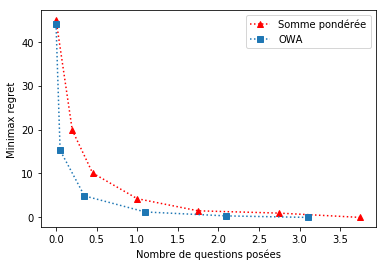

In [49]:
fig = plt.Figure()
ax = fig.add_subplot(111)

mean_minimax_regrets_owa = np.mean(minimax_regrets_owa,axis=0)
mean_minimax_regrets_ws = np.mean(minimax_regrets_ws,axis=0)

mean_nb_queries_owa = np.mean(nb_queries_ev_owa,axis=0)
mean_nb_queries_ws = np.mean(nb_queries_ev_ws,axis=0)

minimax_regrets_hat_owa = savgol_filter(mean_minimax_regrets_owa, 5,4)
minimax_regrets_hat_ws = savgol_filter(mean_minimax_regrets_ws, 5,4)

plt.plot(mean_nb_queries_ws,minimax_regrets_hat_ws,'^r:',label='Somme pondérée')
plt.plot(mean_nb_queries_owa,minimax_regrets_hat_owa,'s:',label='OWA')
plt.xlabel('Nombre de questions posées')
plt.ylabel('Minimax regret')
plt.legend()
plt.savefig('evol_mmr_q.png')
plt.show()

In [50]:
phi = 'weighted sum'
t,q = [],[]
for n,p in [(10,2),(20,2),(30,2),(40,2)]:
    print("\nParamètres : n = "+str(n)+", p = "+str(p))
    mean_t, mean_dist_erreurs, mean_nb_queries = quality_measure_procedure_2_nd_tree(n,p,get_data(n,p),phi)
    t.append(mean_t)
    q.append(mean_nb_queries)


Paramètres : n = 10, p = 2
Temps moyen de calcul :0.006918716430664063s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 2.65

Paramètres : n = 20, p = 2
Temps moyen de calcul :0.05977064371109009s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 6.1

Paramètres : n = 30, p = 2
Temps moyen de calcul :0.2254194974899292s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 7.75

Paramètres : n = 40, p = 2
Temps moyen de calcul :0.5324467182159424s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 7.8

Paramètres : n = 50, p = 2
Temps moyen de calcul :1.8062838077545167s
Erreur moyenne par rapport à la solution optimale du décideur : 0.0
Nombre moyen de questions posées : 8.05

Paramètres : n = 60, p = 2
Temps moyen de calcul :6.468482744693756s
Erreur moyenne par rapport à la so